Accuracy: 0.7642276422764228
              precision    recall  f1-score   support

           0       0.82      0.42      0.55        43
           1       0.75      0.95      0.84        80

    accuracy                           0.76       123
   macro avg       0.79      0.68      0.70       123
weighted avg       0.78      0.76      0.74       123



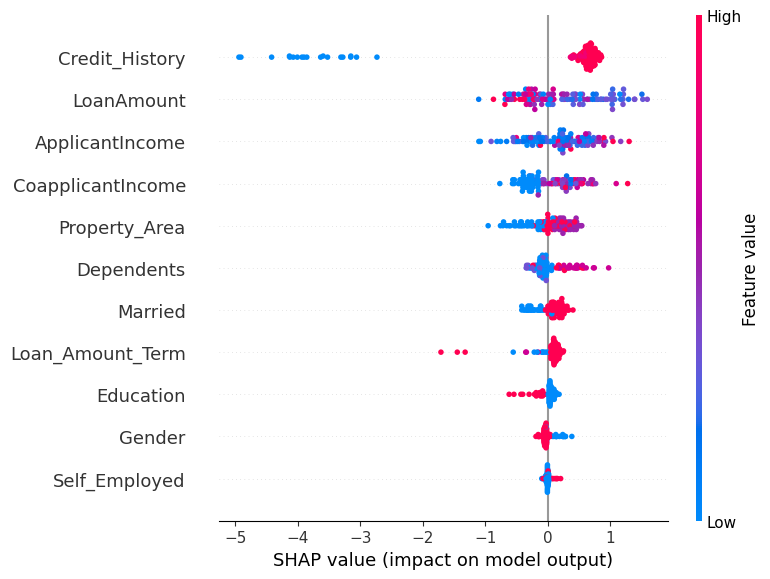

Predictions on test set: [1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0
 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0
 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1
 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1
 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1
 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap

# Load datasets directly from session (Colab uploaded files)
train_df = pd.read_csv('loan-train.csv')
test_df = pd.read_csv('loan-test.csv')

# Drop 'Loan_ID' from both datasets to maintain consistency
train_df.drop(columns=['Loan_ID'], errors='ignore', inplace=True)
test_df.drop(columns=['Loan_ID'], errors='ignore', inplace=True)

def preprocess_data(df):
    df = df.copy()

    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Handling missing values
    num_imputer = SimpleImputer(strategy='mean')  # For numerical columns
    cat_imputer = SimpleImputer(strategy='most_frequent')  # For categorical columns

    df[num_cols] = num_imputer.fit_transform(df[num_cols])
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    # Encoding categorical variables
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Feature Scaling
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    return df, label_encoders, scaler

# Preprocess train and test data
train_df, train_encoders, train_scaler = preprocess_data(train_df)
test_df, _, _ = preprocess_data(test_df)  # No need to reuse label encoders/scalers

# Ensure test_df has the same feature columns as train_df
missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Add missing columns with default values

test_df = test_df[train_df.columns.drop('Loan_Status', errors='ignore')]  # Reorder columns

# Define features and target
X = train_df.drop(columns=['Loan_Status'])
y = train_df['Loan_Status']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

# Feature Importance using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)

# Predict on Test Data
test_predictions = model.predict(test_df)
print("Predictions on test set:", test_predictions)